# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

##### Цель проекта:

Провести анализ и подготовить план действий по удержанию клиентов.

А именно:
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

# План работ

1. <a href='#1'> Изучение файлов с данными, получение общей информации, загрузка библиотек  </a>




2. <a href='#2'> Исследовательский анализ данных </a>


3. <a href='#3'> Построим модель прогнозирования оттока клиентов </a>



4. <a href='#4'> Сделаем кластеризацию клиентов</a>


5. <a href='#5'>  Вывод </a>

<a id='1'></a>
### Изучение файлов с данными, получение общей информации, загрузка библиотек 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

In [2]:
# настройка отображения
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
gym=pd.read_csv('/datasets/gym_churn.csv')
gym.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0
5,1,1,0,0,1,1,1,34,450.74,1.00,3,2.62,2.64,0
6,1,1,1,1,0,6,1,32,94.27,6.00,2,1.14,1.28,0
7,0,1,0,0,1,1,0,30,217.79,1.00,0,1.21,1.05,1
8,1,1,1,1,1,1,1,23,45.41,1.00,1,1.11,1.06,0
9,0,1,0,0,1,1,0,31,65.31,1.00,11,1.81,1.95,0


<a id='2'></a>
### Исследовательский анализ данных

- Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения (пригодится метод describe());
- Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());
- Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
- Построим матрицу корреляций и отобразим её.

In [4]:
def inspect(df):
    display(df.head()) 
    print ('Количество дубликатов -', df.duplicated().sum())
    numeric_columns=df.describe().columns
    display(df.shape)
    display(df.describe())
    df.columns = df.columns.str.lower()
    display()

    df.info() 
    return df
gym = inspect(gym)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


Количество дубликатов - 0


(4000, 14)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Категориальных признаков нет, пропущенных значений и дубликатов в данных также не имеется. Названия столбцов привели к нижнему регистру.

В зал ходят одинаковое кол-во мужчин и женщин,большинство тех , кто живет или рядом работает, с реднем покупают абонементы на 6 мес., средний возраст посетителей клуба- 29 лет, в среднем тратят дополнительно в клубе -146.94	 у.е., среднй лайфтайм 4 мес., ушедших клиентов 27%.

In [5]:
#сгруппируем данные по столбцу 'churn' посчитаем средние значения признаков: 

churn_clients = gym.groupby('churn').mean().T

churn_clients.columns=['not_churn', 'churn']
churn_clients


,not_churn,churn
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Судя по таблице, можно сделать вывод, что в клубе остались те клиенты, кто : 

- живет рядом или работает, 
- является сотрудником компании-партнёра клуба,
- пришел в рамках акции «приведи друга», 
- посещает групповые занятия, 
- тратит больше на доп. услуги клуба,
- до конца контракта 6 мес,
- является постоянным клиентом,
- в среднем посещает клуб 2 раза в неделю

In [6]:
#список количественных переменных
list1=['age', 'lifetime', 'contract_period', 'avg_additional_charges_total', 'month_to_end_contract', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
#список категориальных пременных
list2=['gender','near_location', 'partner', 'promo_friends','phone', 'group_visits']

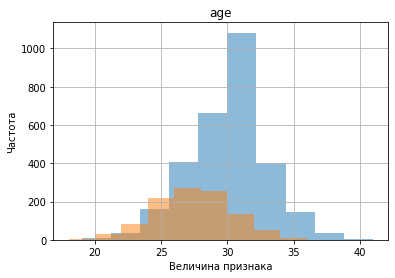

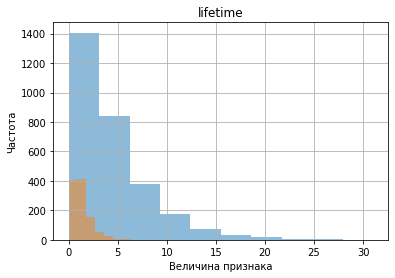

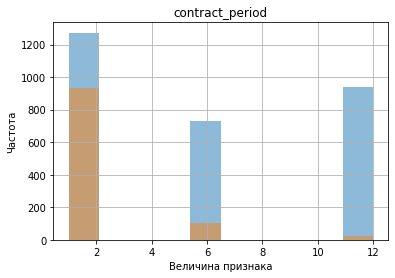

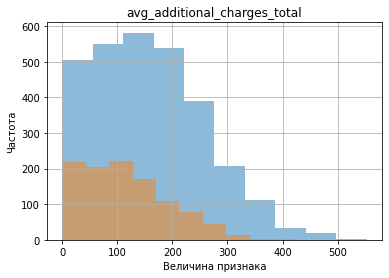

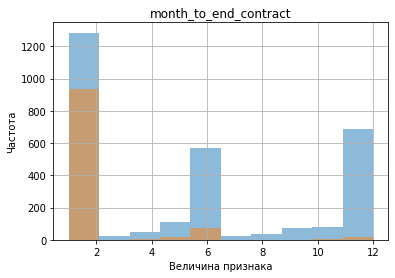

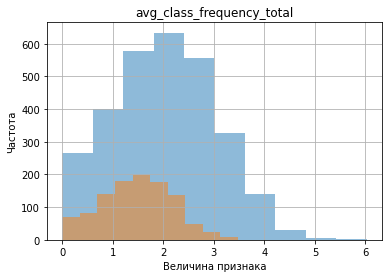

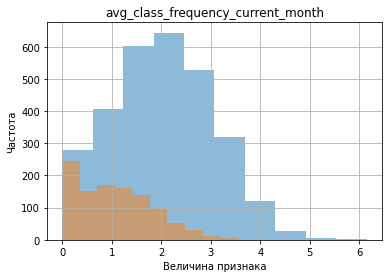

In [7]:
#построим столбчатые диаграммы количественных переменных и распределения признаков
for i in list1:
    fig, ax = plt.subplots()
    gym.groupby('churn')[i].hist(alpha=0.5)
    plt.xlabel("Величина признака")
    plt.ylabel("Частота")
    plt.title(i)
    plt.show()

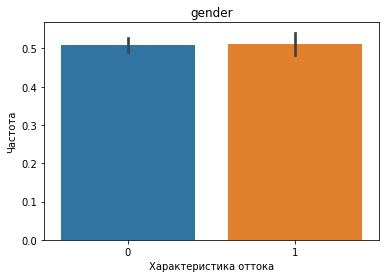

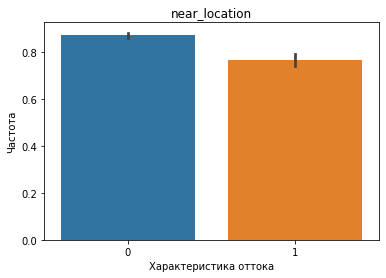

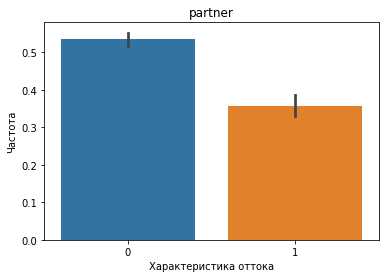

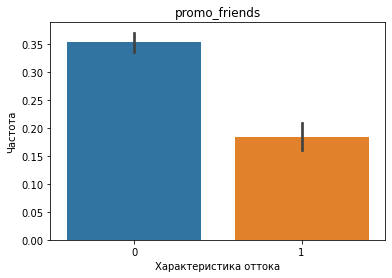

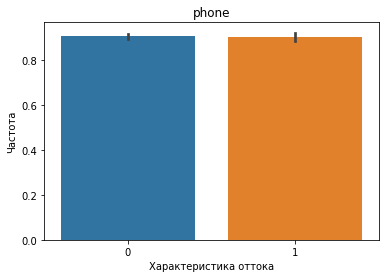

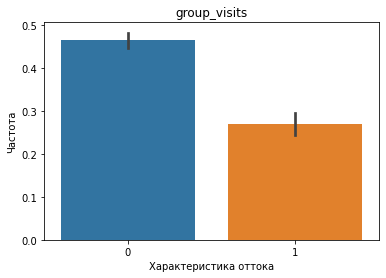

In [8]:
#построим столбчатые диаграммы категориальных  переменных и распределения признаков
for i in list2:
    sns.barplot(data=gym, x='churn', y=i)
    plt.xlabel("Характеристика оттока")
    plt.ylabel("Частота")
    plt.title(i)
    plt.show()

По графикам можем заметить, что в клубе не задерживаются молодые люди от 18-35, у кого клубная карта не более чем на 2 мес, и в основном те у кого до конца контракта 1-2 мес, также посещают они зал не очень часто 1-2 р в неделю.

Также, как ранее было замечено, отваливаются те, кто не живет/работает рядом с залом, не является сотрудником компании-партнёра клуба, и пришел не в рамках акции «приведи друга».

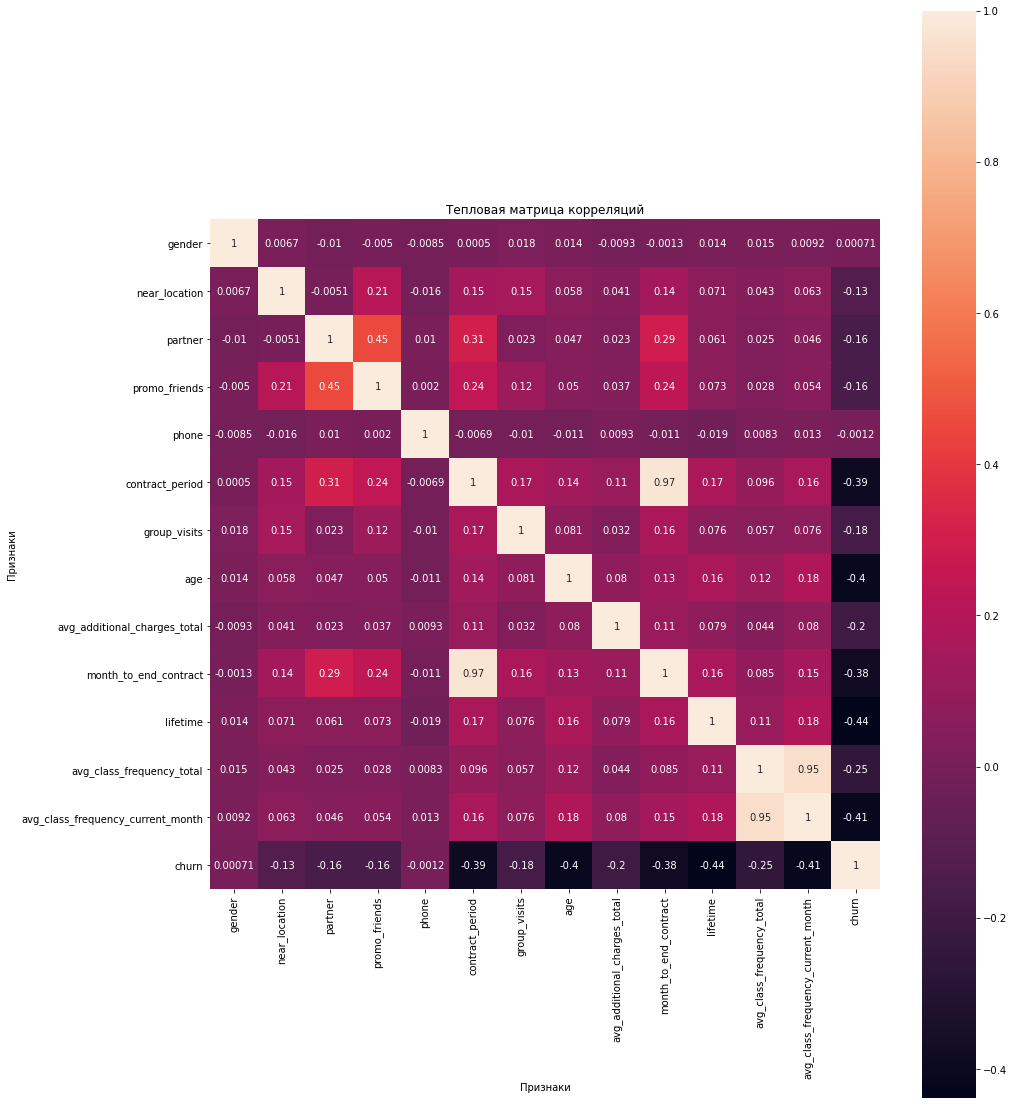

In [10]:
#Построим матрицу корреляций

cm=gym.corr()
fig, ax = plt.subplots(figsize=(15, 20))
sns.heatmap(cm, annot=True, square=True)
plt.title('Тепловая матрица корреляций')
plt.xlabel("Признаки")
plt.ylabel("Признаки")
plt.show()

Судя по графику, сильнее всего коррелируют следующие признаки:
    
    'Month_to_end_contract'-'Contract_period'
    'Avg_class_frequency_current_month'-'Avg_class_frequency_total
  
Чтобы избавиться от мультиколлинеарности, удалим из датафрейма сильно коррелирующие признаки.   

In [11]:
gym.drop('month_to_end_contract', axis = 1, inplace = True)
gym.drop('avg_class_frequency_current_month', axis = 1, inplace = True)


In [12]:
gym

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,6,1,29,14.23,3,0.02,0
1,0,1,0,0,1,12,1,31,113.20,7,1.92,0
2,0,1,1,0,1,1,0,28,129.45,2,1.86,0
3,0,1,1,1,1,12,1,33,62.67,2,3.21,0
4,1,1,1,1,1,1,0,26,198.36,3,1.11,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.41,8,2.28,0
3996,0,1,0,0,1,1,1,29,68.88,1,1.28,1
3997,1,1,1,1,1,12,0,28,78.25,2,2.79,0
3998,0,1,1,1,1,6,0,32,61.91,3,1.63,0


<a id='3'></a>
### Построим модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

поделим данные на обучающую и валидационную выборку функцией train_test_split().
Обучим модель на train-выборке двумя способами: 1) логистической регрессией, 2) случайным лесом. 3) Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?

In [13]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop('churn', axis=1)
y = gym['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]


In [14]:

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 

# обучим модель случайного леса
rf_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]


In [15]:
#Оценим метрики accuracy, precision и recall для модели логистической регрессии на валидационной выборке
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, lr_predictions)))


Accuracy: 0.91
Precision: 0.83
Recall: 0.83


In [16]:
#Оценим метрики accuracy, precision и recall для модели случайного леса на валидационной выборке
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, rf_predictions)))

Accuracy: 0.89
Precision: 0.81
Recall: 0.79


In [17]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))


In [18]:
print_all_metrics(y_test, lr_predictions, lr_probabilities, title='Метрики для модели логистической регрессии:')
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.83
	Recall: 0.83
	F1: 0.83
	ROC_AUC: 0.96
Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.79
	F1: 0.80
	ROC_AUC: 0.95


В результате сравнения двух моделей, метрики доля правильных ответов(accuracy)-92%, точность(precision) и полнота(recall)-84% и 82% соответственно, выше при применении модели логистической регрессии. 



<a id='4'></a>
### Кластеризация клиентов

Отложим в сторону столбец с оттоком и проведите кластеризацию объектов (клиентов):
- Стандартизируем данные.
- Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму.  На основании полученного графика предположим, какое количество кластеров можно выделить.
- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).
- Посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
- Построим распределения признаков для кластеров. Можно ли что-то заметить по ним?
- Для каждого полученного кластера посчитаем долю оттока (методом groupby()). 
Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [19]:
#стандартизация и нормализация  данных
scaler=StandardScaler()
x_sc=scaler.fit_transform(X)

linked = linkage(x_sc, method = 'ward') 

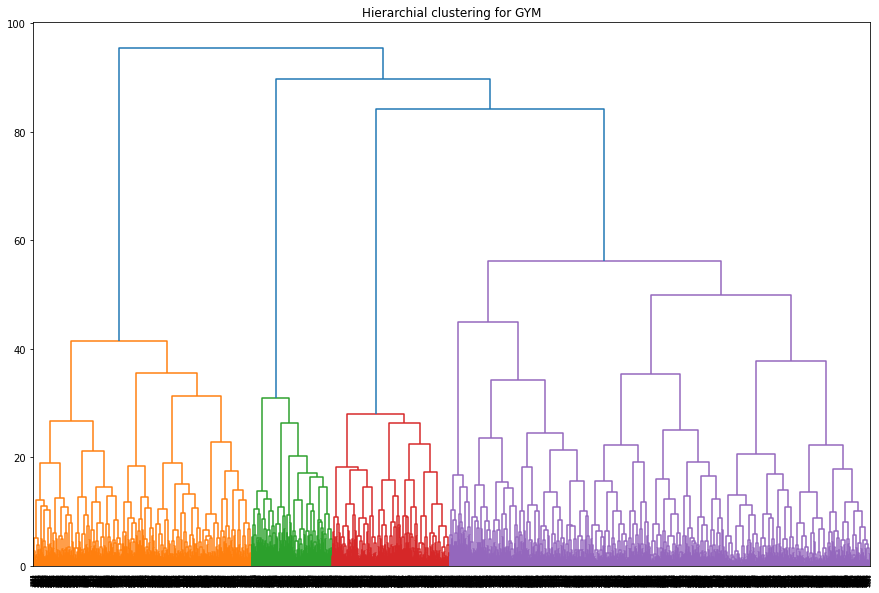

In [20]:
# визуализируем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Предложенное оптимальное число кластеров 4 — 4 разных цветов на графике

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [21]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc)
# сохраняем метки кластера в поле нашего датасета
gym['cluster'] = labels
# Переименуем названия кластеров
gym.loc[gym['cluster']==0, 'cluster'] = 'cluster_1'
gym.loc[gym['cluster']==1, 'cluster'] = 'cluster_2'
gym.loc[gym['cluster']==2, 'cluster'] = 'cluster_3'
gym.loc[gym['cluster']==3, 'cluster'] = 'cluster_4'
gym.loc[gym['cluster']==4, 'cluster'] = 'cluster_5'

# выводим статистику по средним значениям признаков по кластеру
clusters = gym.groupby(['cluster']).mean()
clusters

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster,,,,,,,,,,,,
cluster_1,0.50,0.00,0.49,0.08,1.00,3.03,0.24,28.72,137.54,3.06,1.77,0.40
cluster_2,0.49,1.00,0.96,0.89,1.00,7.66,0.46,29.54,155.86,4.38,1.98,0.12
cluster_3,0.51,1.00,0.24,0.06,1.00,2.82,0.00,28.77,143.38,3.34,1.80,0.38
cluster_4,0.54,1.00,0.25,0.08,1.00,4.53,1.00,29.54,148.09,3.76,1.94,0.20
cluster_5,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,3.94,1.85,0.27


In [22]:
#список количественных переменных
list=['age', 'lifetime', 'contract_period', 'avg_additional_charges_total', 'avg_class_frequency_total']
#список категориальных пременных
list0=['gender','near_location', 'partner', 'promo_friends','phone', 'group_visits']

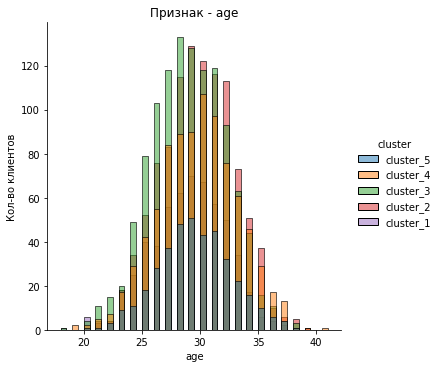

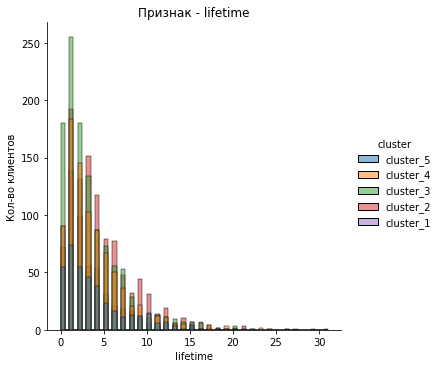

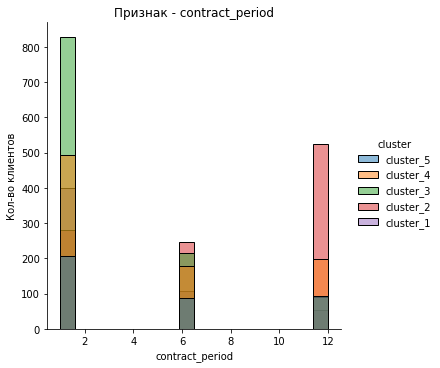

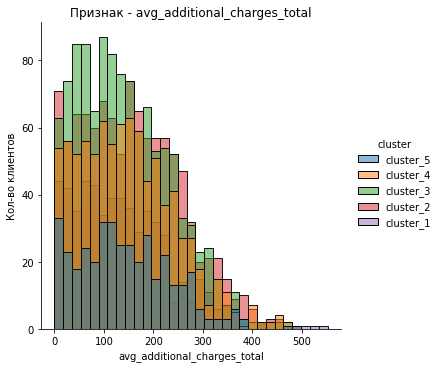

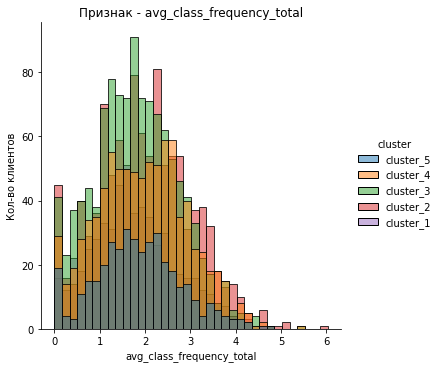

In [23]:
#построим столбчатые диаграммы количественных переменных и распределения признаков
for i in list:
    sns.displot(gym, x=gym[i], hue='cluster', kind='hist' ) # 'hist', 'kde', 'ecdf'
    plt.title(f'Признак - {i}')
    plt.ylabel("Кол-во клиентов")

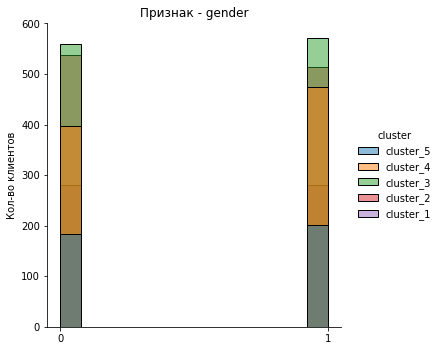

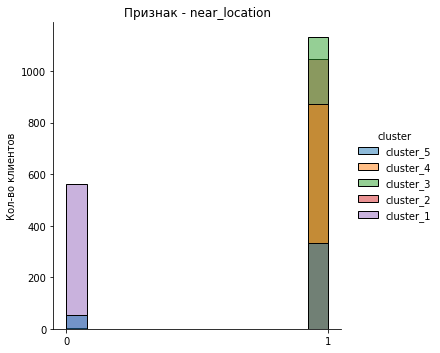

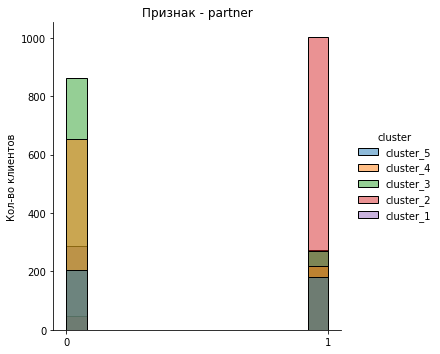

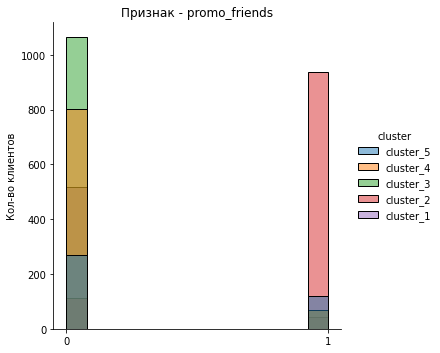

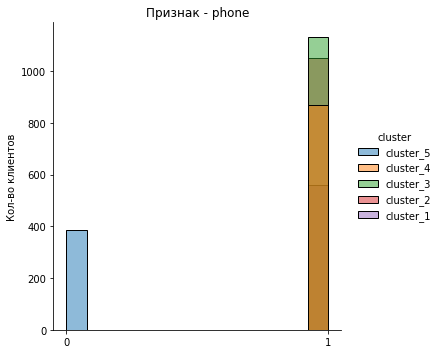

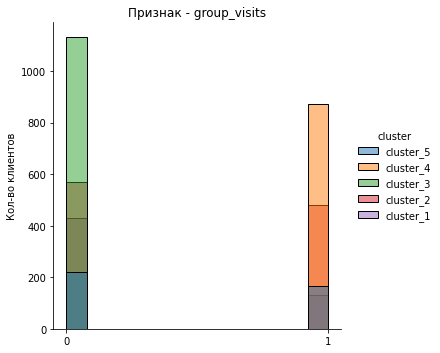

In [24]:
#Построим распределения категориальных  признаков для кластеров 

for i in list0:
    sns.displot(gym, x=gym[i], hue='cluster')
    plt.xticks([0, 1])
    plt.title(f'Признак - {i}')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel("")


Судя по графикам в кластер_2 и кластер_4 попадают клиенты в возрасте от 18 лет и до 30, которые не являются постоянными клиентами клуба, длительность абонемента 1 мес, до конца конракта также 1 -1,5 мес, посещают зал примерно 1-2 р в неделю, не являются партнерами и пришли не по акции приведи друга, не посещают групповые занятия.В кластер_3 попали те,кто живет и работает не рядом с клубом. Клиенты из Кластер_2 не оставляют номера телефонов.

In [25]:
# Для каждого полученного кластера посчитаем долю оттока
(gym
     .groupby('cluster')['churn']
     .mean()
     .reset_index()
     .sort_values(by='churn', ascending=False)
     .reset_index(drop=True))

,cluster,churn
0,cluster_1,0.40
1,cluster_3,0.38
2,cluster_5,0.27
3,cluster_4,0.20
4,cluster_2,0.12


Доля оттока у кластера_4 -51%  самая высокая, не сильно отстает кластер_3- 44%.

<a id='5'></a>
### Вывод: 

Цель проекта:

Провести анализ и подготовить план действий по удержанию клиентов.

А именно: научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента; сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства; проанализировать основные признаки, наиболее сильно влияющие на отток; сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

В ходе работы пропущенных значений и дубликатов не было выявлено. 

Названия столбцов привели к нижнему регистру.

По построенным гистограммам и распределения признаков выявили, что в клубе не задерживаются молодые люди от 18-35, у кого клубная карта не более чем на 2 мес, и в основном те у кого до конца контракта 1-2 мес, также посещают они зал не очень часто 1-2 р в неделю.

Также, как ранее было замечено, отваливаются те, кто не живет/работает рядом с залом, не является сотрудником компании-партнёра клуба, и пришел не в рамках акции «приведи друга». 

По матриции корреляции видно, что сильнее всего коррелируют следующие признаки:

'Month_to_end_contract'-'Contract_period'
'Avg_class_frequency_current_month'-'Avg_class_frequency_total
'Promo_friends'-'Partner'

В результате сравнения метрик двух моделей логистической регрессии и случайного леса, метрики модели логистической регрессии показали более точные результаты, доля правильных ответов(accuracy)-92%, точность(precision) и полнота(recall)-84% и 82% соответственно.

Построили матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисовали дендрограмму. На основании полученного графика предположили оптимальное число кластеров - 4.

Обучили модель кластеризации на основании алгоритма K-Means и спрогнозировали кластеры клиентов -5 кластеров.
Результаты кластеризации:

cluster_1 - лучший кластер, доля оттока всего 3%:
Это те клиенты, кто купил абонемент на 12мес по Промо или Партнер, и проходил уже больше 2 месяцев, и ходят 2-3раза в неделю, те кому больше 30 лет, многие тратят на допуслуги свыше 200, у них осталось 6мес и больше от абонемента, те кто является партнерами и пользуется промо-акциями, любят групповые занятия

cluster_5 - также неплохой, доля оттока около 7%  -Это те клиенты, кто купил абонемент на 6мес  так же как и cluster_1 ходят 2-3раза в неделю, те кому больше 30 лет, многие тратят на допуслуги свыше 200, у них осталось 6мес.

cluster_2 - плохой, доля оттока -27%:
Это те клиенты, кто живет не близко и в основном пришел без промо-акции, те у кого абонемент меньше ,чем на 2 мес, и совсем не оставляют номера телефонов.

cluster_3 - также плохой кластер, доля оттока 44%:
Это клиенты ,которые живут не рядом с клубом. 

cluster_4 - очень плохой кластер - отток  51%:
Клиенты в возрасте от 18 лет и до 30, которые не являются постоянными клиентами клуба, длительность абонемента 1 мес, до конца контракта также 1 -1,5 мес, посещают зал примерно 1-2 р в неделю, не являются партнерами и пришли не по акции приведи друга, не посещают групповые занятия.


Рекомендации:
- для постоянных клиентов, делать скидки и акции на доп.услуги клуба,
- делать скидку на последующее продление абонемента,
- делать упор на клиентов, которые проживают рядом, провести рекламную акцию для привлечения новых(листовки, рекламные щиты),
- установить цены на абонементы 6 и 12 мес чуть меньше, чем на абонементы 1 и 3мес.